In [1]:
%load_ext watermark

## Data dependencies

In [2]:
mfcc_df_path = "../data/CXH2_GY.mfcc.parquet"
w2v_df_path = "../data/CXH2_GY.w2v.parquet"

!sha1sum $mfcc_df_path $w2v_df_path

c5bb2c914f84415e2afbe8c510e08247f9c95974  ../data/CXH2_GY.mfcc.parquet
53afcbbae6cbf63b8b2d4c81fecd44e8dda1f9d6  ../data/CXH2_GY.w2v.parquet


## Load data

In [3]:
import pandas as pd
df_mfcc = pd.read_parquet(mfcc_df_path)
df_w2v = pd.read_parquet(w2v_df_path)

In [4]:
df_mfcc.head(2)

,filename,idx,start_t,end_t,pinyin,char,phone,type,mfcc_first,mfcc_mean
0,CXH2_GY,2,10.666971,10.873312,zi4,自,z,nasp,"[0.0, 0.0, 0.0, 0.0, 0.0, -123.12713, -118.162...","[-51.56747, -52.02446, -52.62525, -53.201782, ..."
1,CXH2_GY,5,11.472899,11.660520,gang1,剛,g,nasp,"[0.0, 0.0, 0.0, 0.0, 0.0, -57.57262, -29.81437...","[-16.012426, -18.668547, -21.123747, -24.16140..."


In [5]:
import numpy as np
from sklearn.manifold import TSNE
import plotly_express as px

phone_labels = df_w2v.phone
w2v_mean = np.vstack(df_w2v.w2v_mean.to_numpy())
mfcc_mean = np.vstack(df_mfcc.mfcc_mean.to_numpy())
SEED = 122

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## W2V phone LDA

In [7]:
trainX, testX, trainY, testY = train_test_split(
                                w2v_mean, phone_labels, test_size=.2,
                                stratify=phone_labels, 
                                random_state=SEED,
                                )

lda_w2v = LinearDiscriminantAnalysis()
lda_w2v.fit(trainX, trainY)

print(classification_report(testY, lda_w2v.predict(testX)))

              precision    recall  f1-score   support

           b       0.77      0.70      0.73        53
           c       0.43      0.27      0.33        11
          ch       0.54      0.74      0.62        19
           d       0.71      0.73      0.72       155
           g       0.56      0.57      0.57        54
           k       0.83      0.78      0.80        45
           p       0.38      0.27      0.32        11
           t       0.69      0.72      0.70        64
           z       0.32      0.31      0.32        29
          zh       0.71      0.71      0.71        62

    accuracy                           0.67       503
   macro avg       0.59      0.58      0.58       503
weighted avg       0.67      0.67      0.66       503



## Visualize

In [8]:
import matplotlib.pyplot as plt

In [9]:
da_mat = lda_w2v.scalings_
da_b = lda_w2v.intercept_

In [10]:
da_mat.shape

(1024, 9)

In [20]:
np.tile(0,10)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [59]:
a_start = 0
a_end = 5
a_N = 50
axes_data = np.zeros((da_mat.shape[1]*a_N+1, da_mat.shape[1]))
axes_labels = np.tile("axes", axes_data.shape[0])
axes_labels[-1] = "origin"
for i in range(da_mat.shape[1]):
    axes_data[(i*a_N):((i+1)*a_N), i] = np.linspace(a_start, a_end, a_N)

In [60]:
import seaborn as sns

# w2v
lda_proj = lda_w2v.transform(w2v_mean)
lda_proj = np.vstack([lda_proj, axes_data])
labels = np.concatenate([phone_labels, axes_labels])

Text(0.5, 1.0, 'Wav2Vec - tSNE on 9 LDA axes')

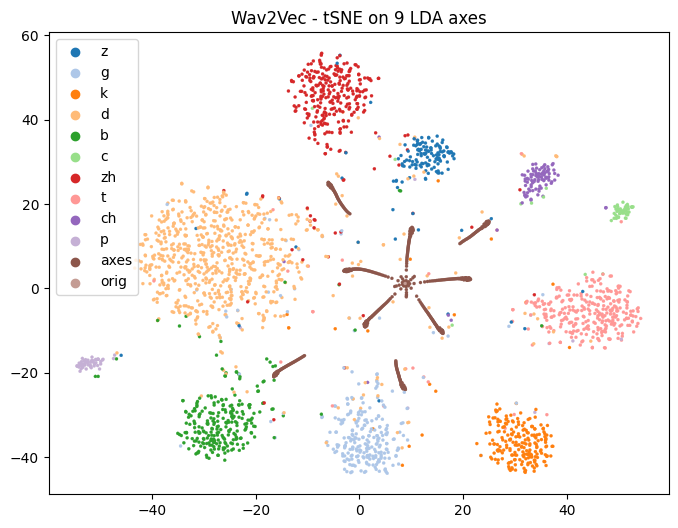

In [61]:
plt.figure(figsize=(8,6))
tsne_proj = TSNE().fit_transform(lda_proj)
sns.scatterplot(x=tsne_proj[:,0], y=tsne_proj[:,1], 
                hue=labels, 
                s=5,
                edgecolor=None,
                legend=True,
                palette="tab20")
plt.title("Wav2Vec - tSNE on 9 LDA axes")

In [66]:
lda_w2v.scalings_.shape

(1024, 9)

In [ ]:
lda_w2v.decision_function(